In [49]:
import time
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from collections import Counter

# natural language toolkit
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation

# import sklearn modules and classification metrics
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score

# pipelines and transformers
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Logistic Regresion model
from sklearn.linear_model import LogisticRegression
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.linear_model import SGDClassifier
# !pip install xgboost
import xgboost as xgb

# for random states
SEED = 20

## Extract and laod Dataset

In [2]:
# extract and load dataset
DATASET_ZIP = 'Datasets/Tweets/tweets_data.zip'
DATASET_TARGET = 'tweets'

# helper extraction
def extract_dataset(source_dir=DATASET_ZIP, target_dir=DATASET_TARGET):
    # takes zip folder and unzips to target destination
    try:
        with zipfile.ZipFile(DATASET_ZIP,'r') as zip_ref:
            zip_ref.extractall(DATASET_TARGET)
    except IOError:
        print('rror: File does not appear to exist.')

# helper load function
def load_dataset(source_dir, dataset_name, sep=','):
    # loads csv data into pandas DataFrame
    csv_path = os.path.join(source_dir, dataset_name)
    tweets = pd.read_csv(csv_path,
                         # for some reason the dataset has more than 2 unused columns
                         # so we only get the first 2, class and text
                         usecols=['Sentiment', 'SentimentText'],
                         error_bad_lines=False,
                         encoding='ISO-8859-1',
                        )
    return tweets

# extract zip file
extract_dataset(DATASET_ZIP, DATASET_TARGET)
# and load data
tweets = load_dataset(source_dir='tweets', dataset_name='tweets_sentiment.csv')

print(f'data frame size:{tweets.shape}')

data frame size:(1048575, 2)


In [3]:
# print some positive samples
tweets[tweets['Sentiment']==0].head(15)

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
7,0,Sunny Again Work Tomorrow :-| ...
10,0,I must think about positive..
12,0,this weekend has sucked so far
13,0,jb isnt showing in australia any more!
14,0,ok thats it you win.


In [4]:
# print some negative samples
tweets[tweets['Sentiment']==1].head(15)

,Sentiment,SentimentText
2,1,omg its already 7:30 :O
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)
11,1,thanks to all the haters up in my face a...
17,1,Feeling strangely fine. Now I'm gonna go l...
22,1,You're the only one who can see this cause...
28,1,"goodbye exams, HELLO ALCOHOL TONIGHT"
38,1,uploading pictures on friendster
41,1,(: !!!!!! - so i wrote something last week. ...


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
Sentiment        1048575 non-null int64
SentimentText    1048575 non-null object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


### Time to get some understanding of the data

Before we do anything we could do some basic text clean up, like triming spaces and converting everything to lower case, etc.

In [6]:
# here a copy is created in order to do some data exploration
data_exploration = tweets.copy()

In [7]:
def text_cleanup(dataframe, text_column='SentimentText'):
    """
    This function is meant to do some text cleaning:
    Removes leading white spaces, HTML links, converts to lowercase.
    """
    
    # trim/strip left and right whitespaces
    dataframe[text_column] = dataframe[text_column].str.strip()
    # text to lowercase
    dataframe[text_column] = dataframe[text_column].str.lower()
    # removes hyperlinks - I will assume that they don't add much value
    dataframe[text_column] = [re.sub(r'https?:\/\/.*\/\w*', '', w) for w in dataframe[text_column]]
    # removes HTML special sintax such as &amp;
    dataframe[text_column] = [re.sub(r'\&\w*;', '', w) for w in dataframe[text_column]]
    # removes digits
    dataframe[text_column] = [re.sub(r'\d+', '', w) for w in dataframe[text_column]]
    
    return dataframe


def remove_stopwords(sentence):
    """ 
    Gets rid of some english stopwords as there could be some stop words that might be bias towards sadness like not, nor, but, etc.
    """
    # stopwords to ignore based on personal bias (this is a subset of the NLTK full list of english words)
    forbidden_words = ['it', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were',
                       'a', 'an', 'the', 'and', 'of', 'at', 'by', 'for', 'before', 'after', 'above', 'below',
                       'to', 'from', 'then', 'here', 'when', 'so', 'than', 'too', 'very', 's', 't', 'just', 
                       'now','d', 'll', 'm', 'o', 're', 've', 'y', 'i','you','my','in', 'on', 'have', "i'm", 
                       '-', 'its', 'im', 'u', 'what']
    
    sentence = ' '.join([w for w in sentence.split(' ') if w not in forbidden_words])
    
    return sentence

def tokenize_sentence(dataframe, text_column='SentimentText'):
    """
    Converts sentence into list of words.
    """
    dataframe[text_column] = [w.split() for w in dataframe[text_column]]
    
    return dataframe
    

Full list of english stop words from NLTK: (print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

#### Text transformations:

<ul>
    <li>Trim left and right white spaces</li>
    <li>Text to lowercase</li>
    <li>Remove hyperlinks</li>
    <li>Remove HTML tags</li>
    <li>Remove digits</li>
    <li>Remove subset of stopwords</li>
    <li>Stemming</li>
</ul>


In [8]:
# apply above data transformations:
data_exploration = text_cleanup(data_exploration, text_column='SentimentText')
data_exploration['SentimentText'] = data_exploration['SentimentText'].apply(remove_stopwords)

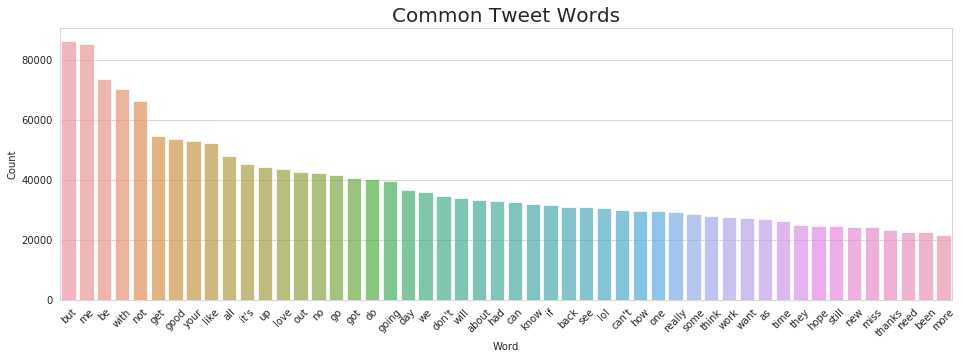

In [9]:
# get top most used words in tweets
top_n = 50
top_words = pd.Series(' '.join(data_exploration['SentimentText']).split()).value_counts()[:top_n]

# create subplots to save some space
plt.figure(figsize=(16,5))
plt.title('Common Tweet Words', fontsize=20)

# seaborn barplot
chart = sns.barplot(x=top_words.index, y=top_words.values, alpha=0.7)

# set label and rotate x ticks
chart.set(xlabel='Word', ylabel='Count')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

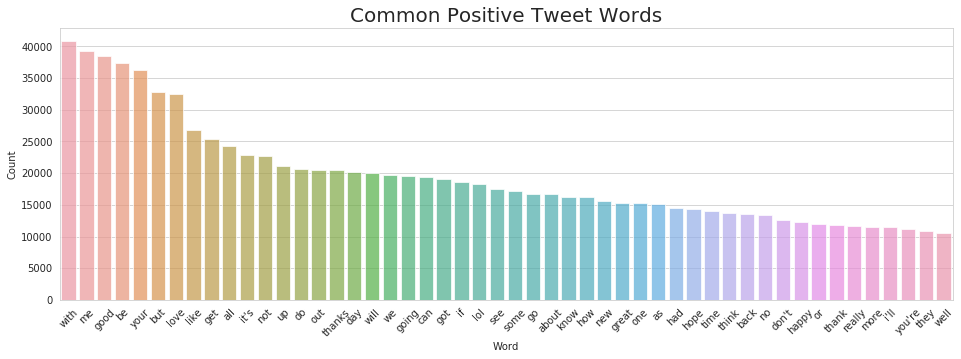

In [10]:
# get top most negative words in tweets
negative_tweets = data_exploration['SentimentText'][data_exploration['Sentiment']==1]
top_words = pd.Series(' '.join(negative_tweets).split()).value_counts()[:top_n]

# create subplots to save some space
plt.figure(figsize=(16,5))
plt.title('Common Positive Tweet Words', fontsize=20)

# seaborn barplot
chart = sns.barplot(x=top_words.index, y=top_words.values, alpha=0.7)

# set label and rotate x ticks
chart.set(xlabel='Word', ylabel='Count')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

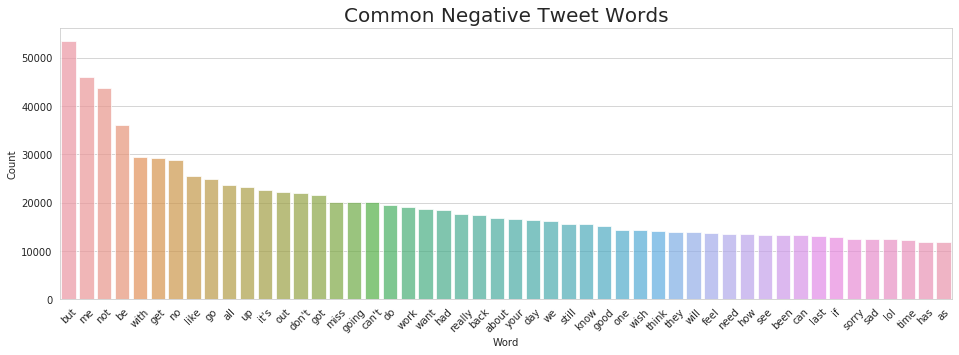

In [11]:
# get top most negative words in tweets
positive_tweets = data_exploration['SentimentText'][data_exploration['Sentiment']==0]
top_words = pd.Series(' '.join(positive_tweets).split()).value_counts()[:top_n]

# create subplots to save some space
plt.figure(figsize=(16,5))
plt.title('Common Negative Tweet Words', fontsize=20)

# seaborn barplot
chart = sns.barplot(x=top_words.index, y=top_words.values, alpha=0.7)

# set label and rotate x ticks
chart.set(xlabel='Word', ylabel='Count')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [12]:
def compare_word(word, data):
    # takes a word, search the given dataframe and plots positive vs negative
    
    row_match = data[data['SentimentText'].str.contains(word)]
    pos = row_match[row_match['Sentiment']==1].shape[0]
    neg = row_match[row_match['Sentiment']==0].shape[0]

    plt.figure(figsize=(12,3))
    plt.title(word.title(), fontsize=20)
    # pallete gets a random color theme every time
    cahrt = sns.barplot(x=['Positive', 'Negative'], 
                        y=[pos,neg], 
                        alpha=0.7,
                        palette=np.random.choice(sorted(plt.cm.cmap_d)))
    chart.set(xlabel='Word', ylabel='Count');

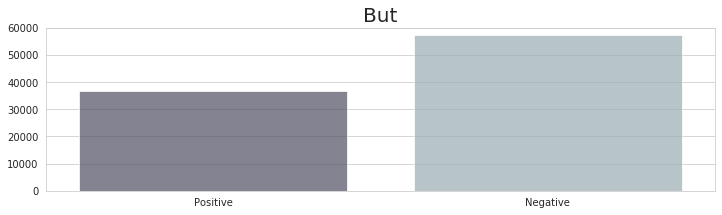

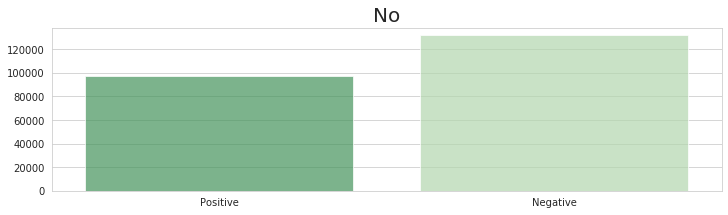

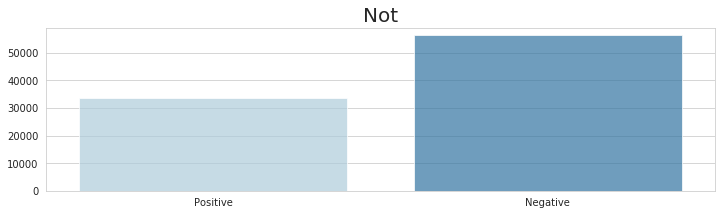

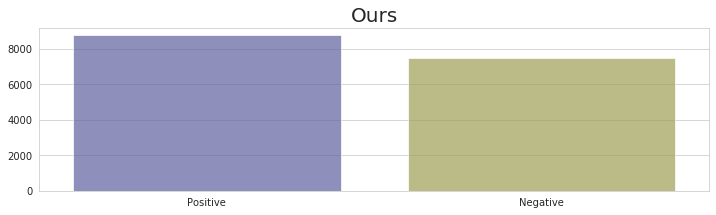

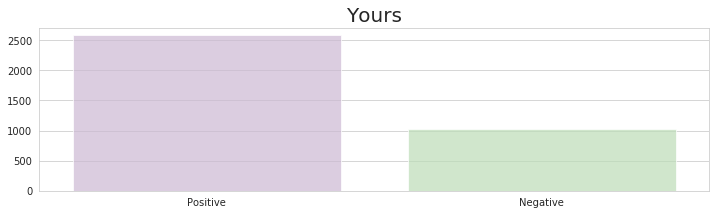

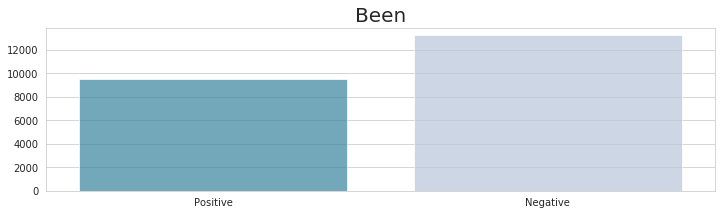

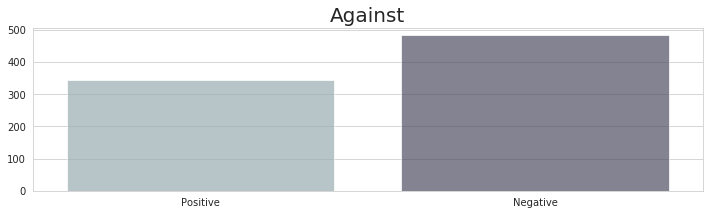

In [13]:
# we can see that some stopwords will probably help the models make a desition
stopwords = ('but', 'no', 'not', 'ours', 'yours', 'been', 'against')

for w in stopwords:
    compare_word(word=w, data=data_exploration)

Lest find out if the day of the week makes much difference between the classes

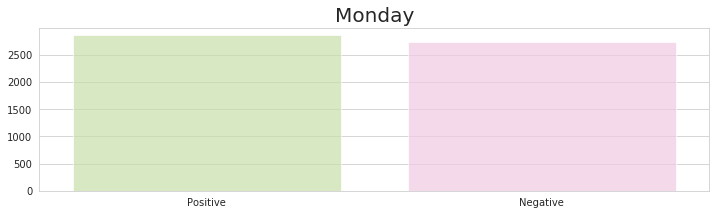

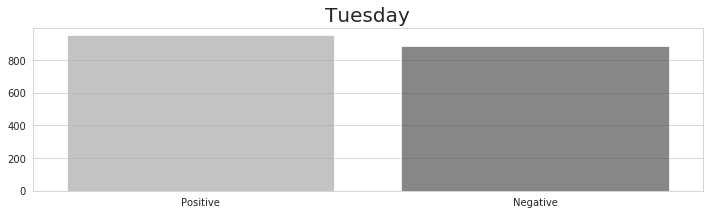

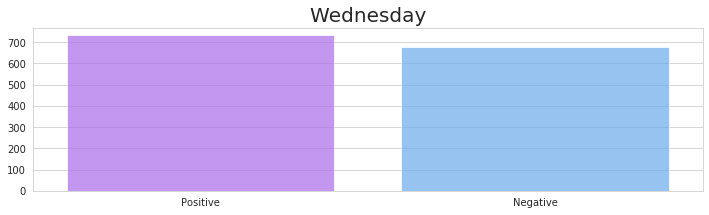

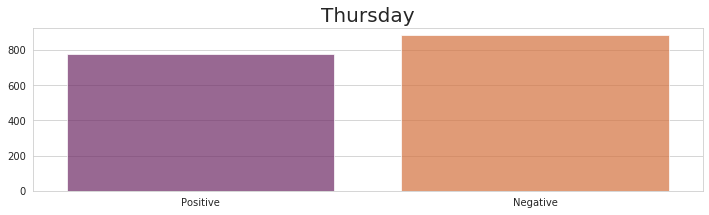

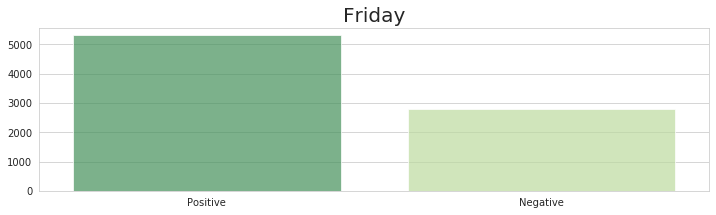

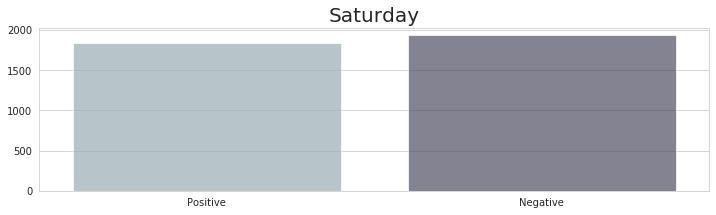

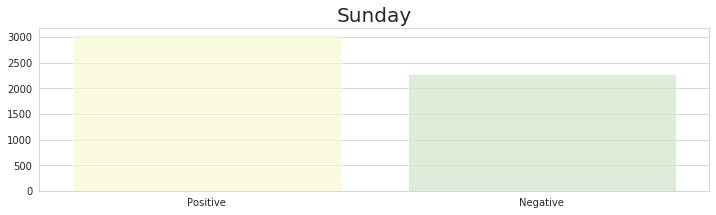

In [14]:
# from this data only friday and sunday seems to make a difference in peoples sentiment.
week_days = ('monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday')

for day in week_days:
    compare_word(word=day, data=data_exploration)

There is no clear relationship between length and sentiment

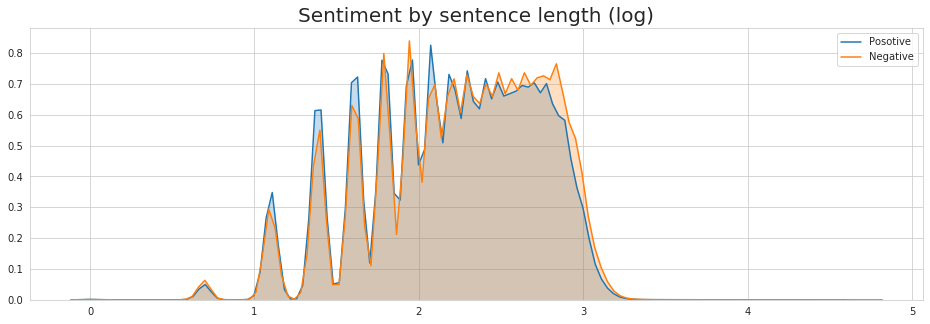

In [15]:
# check if there is any relationship between lenght of the text and sentiment
data_exploration['TextLen'] = [len(sentence.split()) for sentence in data_exploration['SentimentText'].tolist()]

# create subplots to save some space
plt.figure(figsize=(16,5))
plt.title('Sentiment by sentence length (log)', fontsize=20)

for sentiment, val in {'Posotive': 1, 'Negative': 0}.items():
    sns.kdeplot(np.log1p(data_exploration[data_exploration['Sentiment']==val]['TextLen']), 
                label=sentiment, 
                shade=True);

# Train Test Split

In [25]:
# preparing train/test split (80%-20%) and setting random seed for consistency
train_set, test_set = train_test_split(tweets, test_size=0.2, random_state=SEED)

# get TRAINING labels
y_train = train_set['Sentiment']
x_train = train_set.drop('Sentiment', axis=1)

# get TEST labels
y_test = test_set['Sentiment']
x_test = test_set.drop('Sentiment', axis=1)

print(f'Training set size: {x_train.shape}')
print(f'Test set size: {x_test.shape}')

Training set size: (838860, 1)
Test set size: (209715, 1)


###  Preparing corpus for training with custom pipeline transformers

reference for more transformers https://scikit-learn.org/stable/data_transforms.html

In [26]:
class TextStemming(BaseEstimator, TransformerMixin):
    
    def __init_(self):
        self.porter = PorterStemmer()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # custom transformer
        X = X.apply(self.stem_sentences)
        
        return X
    
    def stem_sentences(self, sentence):
        porter = PorterStemmer()
        tokens = sentence.split()
        stemmed_tokens = [porter.stem(token) for token in tokens]
    
        return ' '.join(stemmed_tokens)


class TextCleanUp(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        This method is meant to do some text cleaning:
        Removes left and right white spaces, HTML links, numbers, etc.
        """

        # trim/strip left and right whitespaces
        X = X.str.strip()
        # removes hyperlinks - I will assume that they don't add much value
        X = X.apply(lambda x : re.sub(r'https?:\/\/.*\/\w*', '', str(x)))
        # removes HTML special sintax such as &amp;
        X = X.apply(lambda x : re.sub(r'\&\w*;', '', str(x)))
        # Remove hashtags
        X = X.apply(lambda x : re.sub(r'#\w*', '', str(x)))
        # removes digits
        X = X.apply(lambda x : re.sub(r'\d+', '', str(x)))
        
        return X


In [27]:
# Create data transformation pipeline

# stopwords to ignore based on personal bias (this is a subset of the NLTK full list of english words)
forbidden_words = ['it', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were',
                   'a', 'an', 'the', 'and', 'of', 'at', 'by', 'for', 'before', 'after', 'above', 'below',
                   'to', 'from', 'then', 'here', 'when', 'so', 'than', 'too', 'very', 's', 't', 'just', 
                   'now','d', 'll', 'm', 'o', 're', 've', 'y', 'i','you','my','in', 'on', 'have', "i'm", 
                   '-', 'its', 'im', 'u', 'what']

pipeline = Pipeline([
    # text clean up transformer
    ('text_clean', TextCleanUp()),
    # Porter stemmer used
    ('text_stemming', TextStemming()),
    # tfidf transformer to create a sparse matrix of words
    ('tfidf', TfidfVectorizer(max_features=200000,
                              # n-grams to capture value of single and pair of words
                              ngram_range=(1, 2),
                              lowercase=True,
                              stop_words=forbidden_words)),
])


In [28]:
x_train = pipeline.fit_transform(x_train['SentimentText'])
# x_test = pipeline.transform(x_test['SentimentText'])

In [29]:
# x1 feature shape
x_train[0,:].toarray().shape

(1, 200000)

### Trying multiple models using Cross-Validation

In [80]:
# ROC metric plot 
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve', weight='bold')
    plt.legend(loc='best')
    plt.show();

In [76]:
# Naive Bayes baseline
bayes = BernoulliNB()
# get cross validation scores for 10 folds
scores = cross_val_score(bayes, x_train, y_train, cv=10)

# get predictions and probabilities to plot some metrics
bayes.fit(x_train, y_train)
predictions = bayes.predict(x_train)
probs = bayes.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, probs[:, 1])

print('Cross-Validation avg. score:',np.mean(scores))

Cross-Validation avg. score: 0.7845158916405441


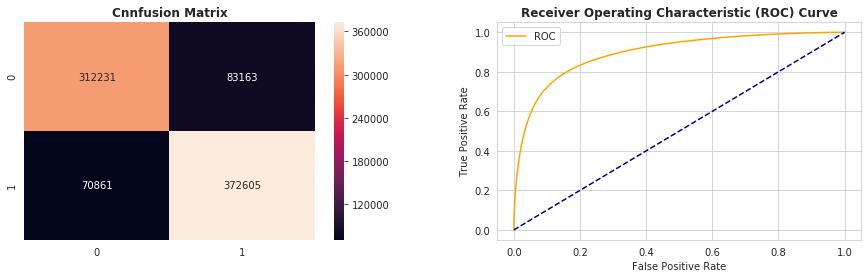

In [81]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axs[0].set_title('Cnnfusion Matrix',  weight='bold')

sns.heatmap(confusion_matrix(y_train, predictions),annot=True, fmt='g', ax=axs[0]);
plot_roc_curve(fpr, tpr);

In [82]:
# Logistic Regression Classifier
lrc = LogisticRegression(random_state=SEED, solver='sag', n_jobs=-1)
# get cross validation scores for 10 folds
scores = cross_val_score(lrc, x_train, y_train, cv=10)

# get predictions and probabilities to plot some metrics
lrc.fit(x_train, y_train)
predictions = lrc.predict(x_train)
probs = lrc.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, probs[:, 1])

print('Cross-Validation avg. score:',np.mean(scores))

Cross-Validation avg. score: 0.8057053595299685


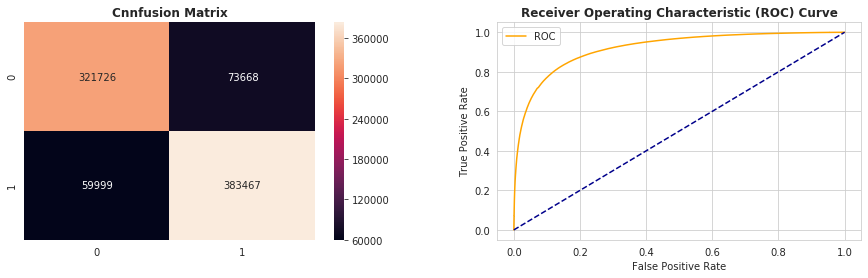

In [83]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axs[0].set_title('Cnnfusion Matrix',  weight='bold')

sns.heatmap(confusion_matrix(y_train, predictions),annot=True, fmt='g', ax=axs[0]);
plot_roc_curve(fpr, tpr);

In [88]:
# Stochastic Gradient Descent
sgd = SGDClassifier(random_state=SEED, loss='modified_huber', n_jobs=-1)
scores = cross_val_score(sgd, x_train, y_train, cv=10)

# get predictions and probabilities to plot some metrics
sgd.fit(x_train, y_train)
predictions = sgd.predict(x_train)
probs = sgd.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, probs[:, 1])

print('Cross-Validation avg. score:',np.mean(scores))

Cross-Validation avg. score: 0.7912738680781398


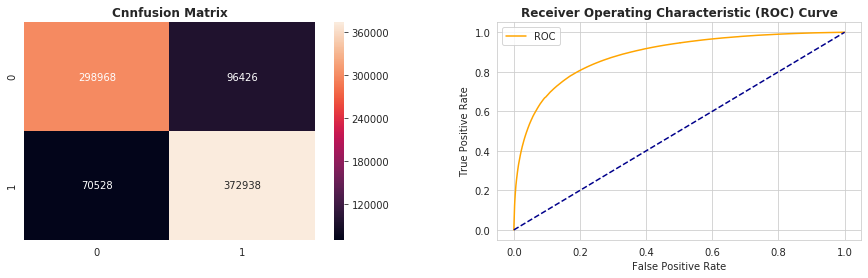

In [89]:
# create subplots to save some space
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axs[0].set_title('Cnnfusion Matrix',  weight='bold')

sns.heatmap(confusion_matrix(y_train, predictions),annot=True, fmt='g', ax=axs[0]);
plot_roc_curve(fpr, tpr);

In [34]:
# XGBoost Binary Classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED)
scores = cross_val_score(xgb_model, x_train, y_train, cv=10)

print('Cross-Validation avg. score:',np.mean(scores))

Cross-Validation avg. score: 0.6919796013195814


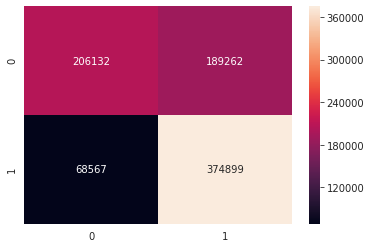

In [43]:
xgb_model.fit(x_train, y_train)
predictions = xgb_model.predict(x_train)
sns.heatmap(confusion_matrix(y_train, predictions),annot=True, fmt='g');